# Module B: Room Labelling and Object Arrangement (with Floorplan images)

## Group21: Victor Song, Xiaoxuan Liu, Lin Zhu, Alice Li

# Introduction

## 1. Project Goals:

Based on the CubiCasa5k dataset, our team aims to build a neural network that labels room types and identifies proper locations to place different types of furniture. The input to our neural network are png files containing scanned or printed versions of floorplans. While we make use of some codes and resources available on Kalervo et al. 's github repository, we propose methods that can improve the segmentation accuracy presented by the original author by means of new network design, data preprocessing and data augmentation. Furthermore, as a stretch goal, we plan to suggest the locations and type of the icon types (including furniture) that could be added next to each floorplan.

## 2. Overall Architecture:


<img src="./deliverable_images/overall_arch2.png"/>

The above diagram shows the proposed end-to-end neural network that takes in a rasterized floorplan image and outputs an icon type to be added to the floor plan.

One of our team's goal was to remove the postprocessor suggested by Kavlero and Liu et al. The intuition behind this approach is that the more portion of the entire pipleline is able to "learn" (that is, able to receive and propagate gradients) , the more likely it is to produce good performance as a generative architecture.

In the sections below, we summarize the three jupyter notebooks we have used to train each neural network (Mask R-CNN, Unet, CGAN). Note that, due to the size of the networks, we cannot load all the modules in this summarized report. 

For individual network's training process, refer to the **/notebooks** folder in https://github.com/osiajod/DS2-final/master.


Let us begin with the Data preparation phase.

In [ ]:
from model_utils.model_process import *
from floortrans.metrics import runningScore
from floortrans.plotting import discrete_cmap
discrete_cmap()

import warnings
warnings.filterwarnings('ignore')

In [6]:
# FOR Unet
from floortrans.loaders.augmentations import (RandomCropToSizeTorch,
                                              ResizePaddedTorch,
                                              Compose,
                                              DictToTensor,
                                              ColorJitterTorch,
                                              RandomRotations)
import torchvision
from torchvision.transforms import RandomChoice
from torch.utils import data
import torch.nn.functional as F
from torch.nn.functional import softmax
from tqdm import tqdm
from skimage import io
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from floortrans.loaders import FloorplanSVG
from floortrans.models import get_model
from floortrans.losses import UncertaintyLoss
from floortrans.metrics import get_px_acc, runningScore
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
import torch
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
import numpy as np
import pandas as pd
import logging
from tensorboardX import SummaryWriter
from floortrans.losses import UncertaintyLoss
from torchvision.transforms import ToPILImage
from IPython.display import Image

# Summary of the Actual Codes

## 3.  Dataloading - Cubicasa dataloader

The data loader code **CubicasaDataset** is in `model_utils/model_process.py`. We use OpenCV tools to automatically annotate the original floorplan images. 




### Data Preprocessing and Augmentation

1) MaskR-CNN
We employed a **MaskR-CNN model** for room detection. MaskR-CNN is a strong tool for both object detection and instance segmentation. At the end, we would try using it to detect each part of the floorplan, search for some specific room on the floorplan and recover the room segmentation map.
MaskR-CNN requires the **data loader** containing following inputs:
image: Raster images preprocessed to $256\times 256$, the training set includes random horizontal flips.

We first used a state-of-the-art object detection model MaskRCNN for room detection and segmentation. Its loss function consists of three parts: the classifier loss, the mask loss and the bounding box regression loss. The advantage of using Mask R-CNN is that we can relate the bounding boxes to  rooms and walls on the segmentation map.
With the right amount of non-maximum supression, the overlap of bounding boxes could give important information about the junctions and walls. The biggest challenge was to automatically annotate the bounding boxes and masks on the floorplan image.  

targets:
- boxes: the bounding boxes of each room instance
- labels: the labels of those rooms
- image_id: the integer identifier of the floorplan
- area: the instance area (based on the mask)
- iscrowd: instances with iscrowd=True will be ignored during evaluation.


2) Unet
image: Raster images preprocessed to have $512\times 512$ resolution.

There were two practical reasons for using U-net with 512x512 resolution, instead of reapplying the previous Mask RCnn to icon type dataset.
The first reason is that, because icons are generally a lot smaller than rooms we wanted to lose less information from the data loading phase. Also, training Mask-RCNN with 512x512 resolution would have taken a lot longer.
Secondly, we set our project’s stretch goal to be icon type generation, which could translate to furniture recommendation in business settings. This means that we want to focus on restoring the diverse icon shapes with best resolution possible. In such case, the bounding box regression for icon types is a rather redundant functionality.

3) CGAN

image: Back to 256x256, but uses the outputs of both the room segmentation network (Mask-Rcnn) and the icon segmentation network (Unet).

We believe that by stacking the information derived from the previous two neural networks, we could train a CGAN that comes up with a recommendation for the new icon / room type.

## 4. Models

A. Mask R-CNN  
B. Unet  
C. CGAN  


## A. Mask R-CNN
For Mask R-Cnn, the strategy was to first extract each room instance mask out from the segmentation map processed in class `House` of the reference work https://github.com/CubiCasa/CubiCasa5k. Then we used traditional tools to find the mask's countour. The countours can further be used to calculate the instance area and find the bounding box vertices.

However, the method above cannot be used to get the accuracy information of walls since different walls are connected in the floorplan and therefore we cannot automatically break them into room pieces and find its target information. As a result, we only processed the other 10 room objects in our training, including "Outdoor", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", and "Undefined".

The ROOM_IDs are:
- Background: 0
- Outdoor:1
- Walls: 2
- Kitchen:3
- Living Room:4
- Bedroom: 5
- Bath: 6
- Entry: 7
- Railing: 8
- Storage: 9
- Garage: 10
- Undefined: 11



#### Exclude some problematic instances before trainig and evaluation

Our dataloader would automatically print out the instances with empty instances. Below shows some problematic examples we found.


In [2]:
def check_folder(folder_name, img_show = True):
    
        
    svg_path ='./data/cubicasa5k'+folder_name+'model.svg'
    img_path ='./data/cubicasa5k'+folder_name+'F1_scaled.png'
    org_img_path ='./data/cubicasa5k'+folder_name+'F1_original.png'
    height, width, _ = cv2.imread(img_path).shape
    height_org, width_org, _ = cv2.imread(org_img_path).shape

    house = House(svg_path, height, width)
    # Combining them to one numpy tensor
    gt = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

    gt = gt.unsqueeze(0)
    gt = torch.nn.functional.interpolate(gt,size=(height_org, width_org),
                                                            mode='nearest')
    gt = gt.squeeze(0)[0]
    
    org_img = plt.imread(org_img_path)
   
    if img_show:
        
        fig = plt.figure()
        ax = plt.subplot(1, 2, 1)
        ax.imshow(org_img)
        ax.set_title('Original Floorplan', fontsize=10)

        ax = plt.subplot(1,2, 2)
        ax.set_title('Ground Truth segmap', fontsize=10)
        ax.imshow(gt, cmap='rooms', vmin=0, vmax=12-0.1)
        
   
        
        
        fig.suptitle(folder_name)
        plt.show()
        
        
    return gt

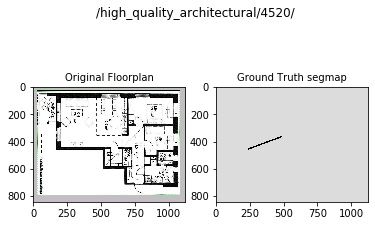

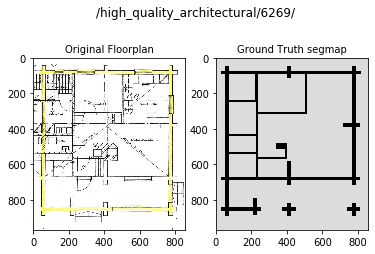

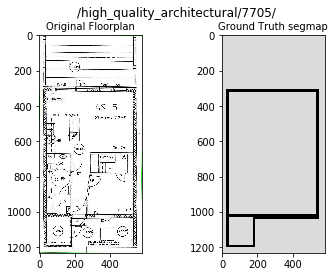

In [3]:
#problematic folders overview
folders = ['/high_quality_architectural/4520/', '/high_quality_architectural/6269/', '/high_quality_architectural/7705/']

for f in folders:
    _ = check_folder(f)
    
    

We can see the ground truth segmentation maps are empty so we simply kick those examples out.

### Training method

The experiment is implemented on AWS Ubuntu 18.04 Deep Learning AMI with NVIDIA K80 GPU. The training script is in `train_maskrcnn.py`. Below are the details:

- model: torchvision.models.detection.maskrcnn_resnet50_fpn
- pretrained on COCO dataset.
- optimizer: SGD, lr = 0.005, momentum=0.9, weight_decay=0.0005
- lr scheduler: step_size=3,gamma=0.1
- epochs: 5, each takes about 100 mins.
- reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

$\mathcal{L} = \mathcal{L}_{classifier} +  \mathcal{L}_{classifier}+ \mathcal{L}_{box reg} + \mathcal{L}_{mask} $ The specific explanation of the losses refers to He et al. https://arxiv.org/pdf/1703.06870.pdf.


In [4]:
#here we use CPU for display
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#use test dataset for display
model, dataset_train, data_loader_train = prepare_model('train')
model, dataset_val, data_loader_val = prepare_model('val')
model, dataset_test, data_loader_test = prepare_model('test')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

The losses are decreasing slowly after the second epoch. 

The beginning total loss was 6.6133. The final loss was a sway between 0.6 and 0.7.

### Postprocessing
The **decoder** Decode_Maskrcnn is in `model_utils/model_process.py`. We use a non-maximum suppression on the number of bounding boxes on each floorplan. The suppression condition is that IoU > 1. For soft segmentation mask, we extract the masks with a value threshold >0.1 (the mask pixel values are within \[0,1\]).

### Overview

In [ ]:
#load model
model.load_state_dict(torch.load('models/maskrcnn_4_resized.pt',map_location='cpu'))

#Input the dataset name, image_id, model and non-maximum suppression threshold.
dm = Decode_Maskrcnn(dataset_val, 0, model, nms = 1) 

### get ground truth

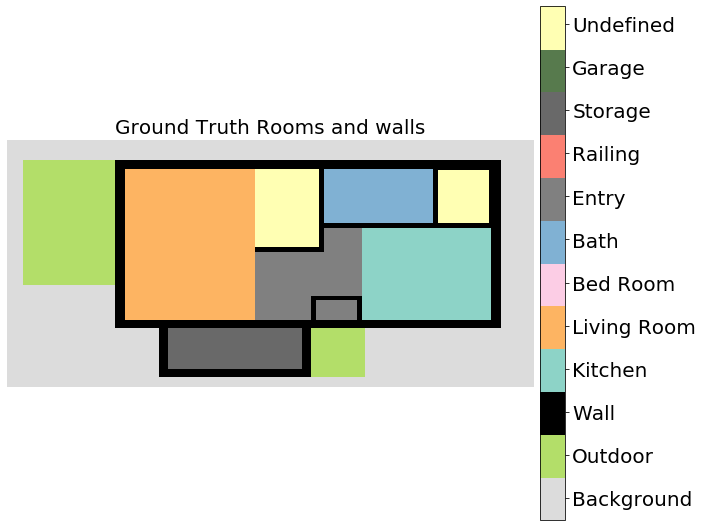

In [6]:
gt = dm.get_groundtruth()

### Get predicted segmentation map

We generated segmentation mask by putting the pieces of instances on all masks together and assigning the ROOM_ID number on that pixel. Since we didn't have walls on the map, we recovered it by adding back countours with some thickness to the segmentation map.

It would be a better idea to add the edges with some thickness to the map. However, for this project we haven't found any efficient way to implement it.
Here we can also see some advantages of the MASKR-CNN. Since the rooms are patches on the image, it is consistent with the function of object detection instead of semantic segmentation. The rooms on the segmentation map are patches without too much overlapping regions on other rooms.

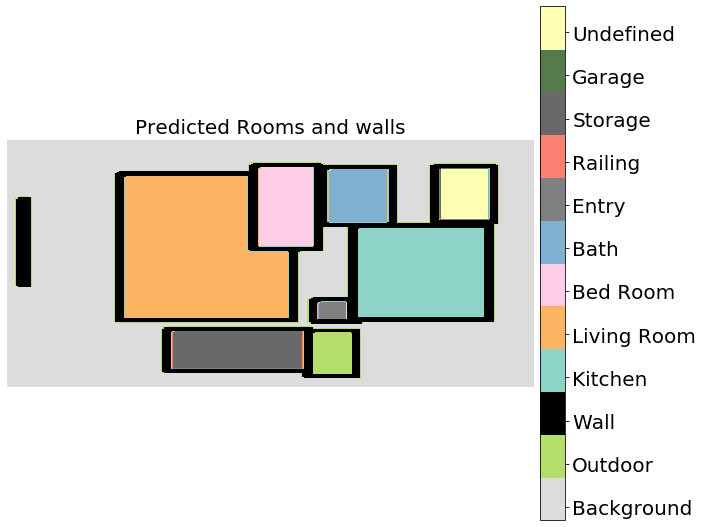

In [7]:
seg_map =  dm.get_segmap(0)

### Room detection

Since we preprocessed the images and bounding boxes with the image size $256 \times 256$, we rescaled the bounding boxes to match the original floorplan.

Our decoder allows to return the proposed regions of some specific rooms.

You can see the model proposed more than one area of bath while in fact there's only one batch on the floorplan. This is a propoerty of object detection models. Maximum suppression thus is very critical to prevent the model from making inaccurate inferences.

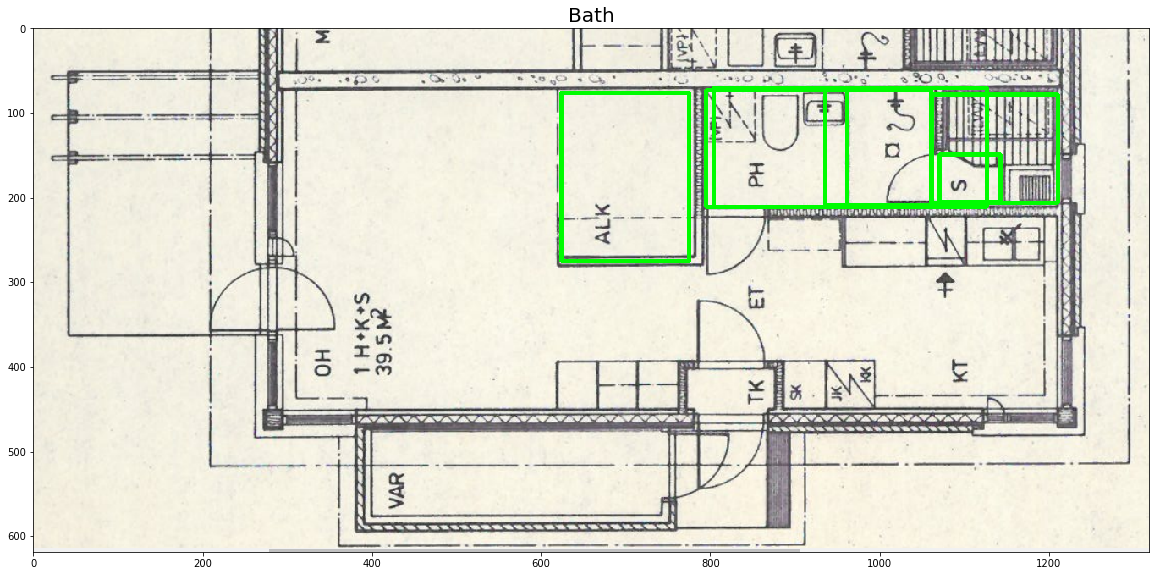

In [8]:
#Enter any room name to search for the room on the floorplan
bed_room =  dm.room_detect(ROOM_LABELS['Bath'])

In [9]:
# report None when no such object detected.
bed_room =  dm.room_detect(ROOM_LABELS['Garage'])

No such object


### Final display

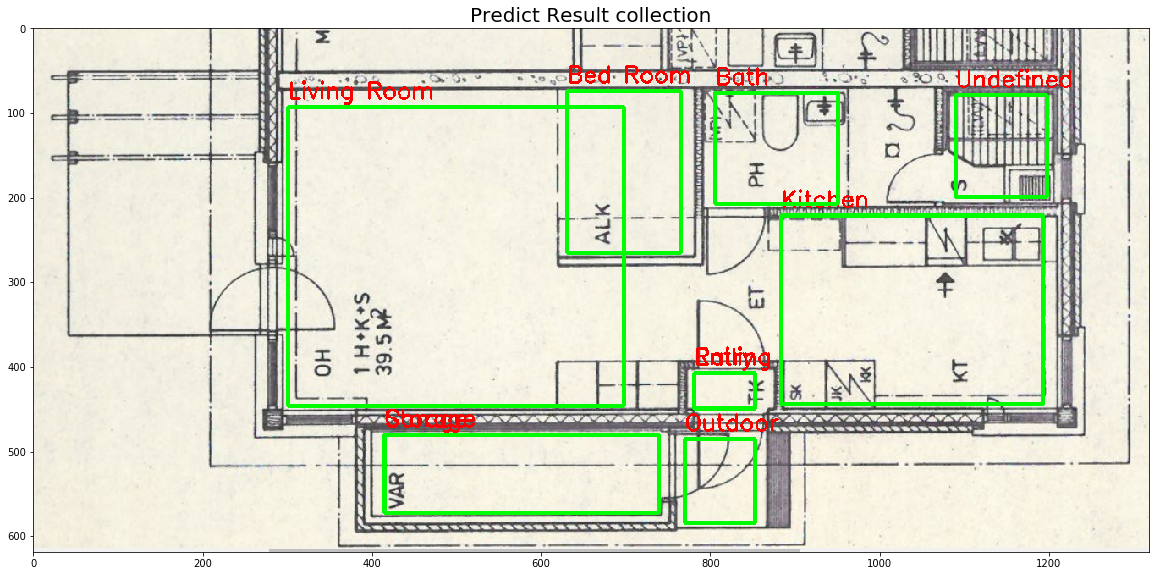

In [10]:
rc = dm.collect_result()

### More examples in test result

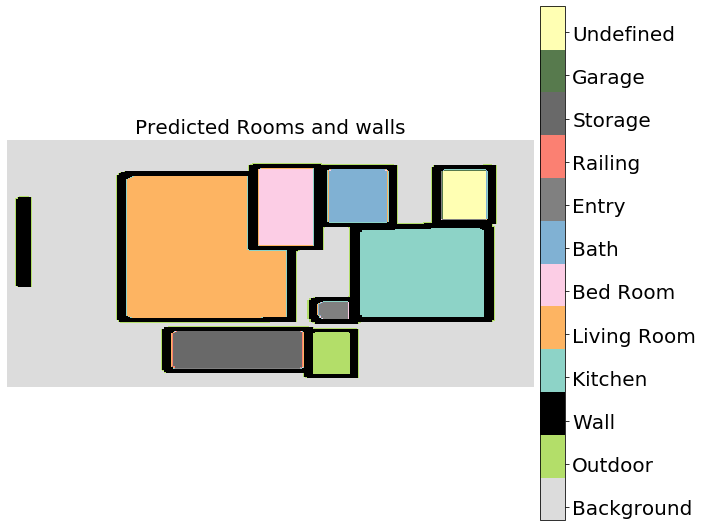

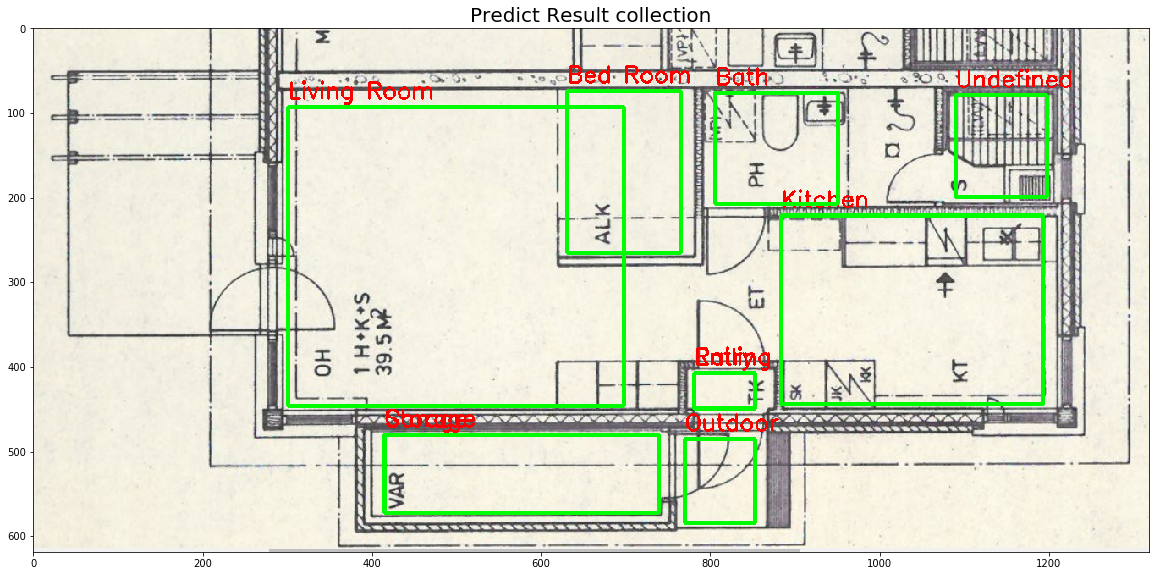

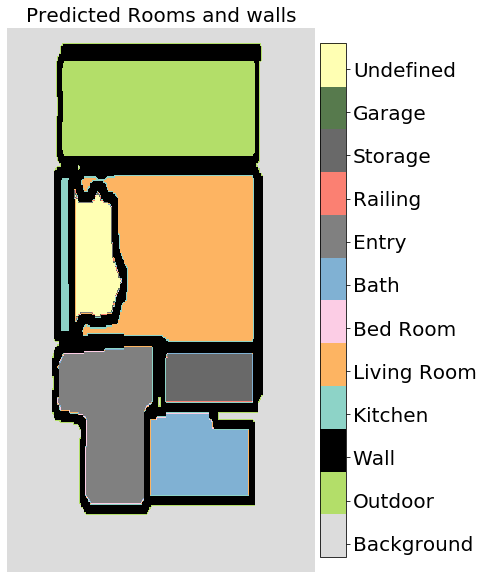

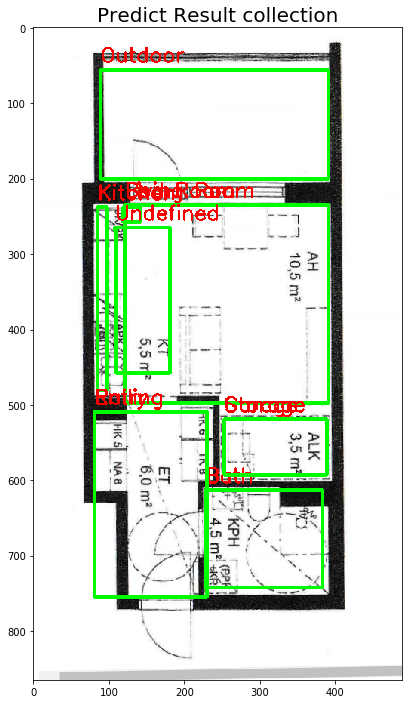

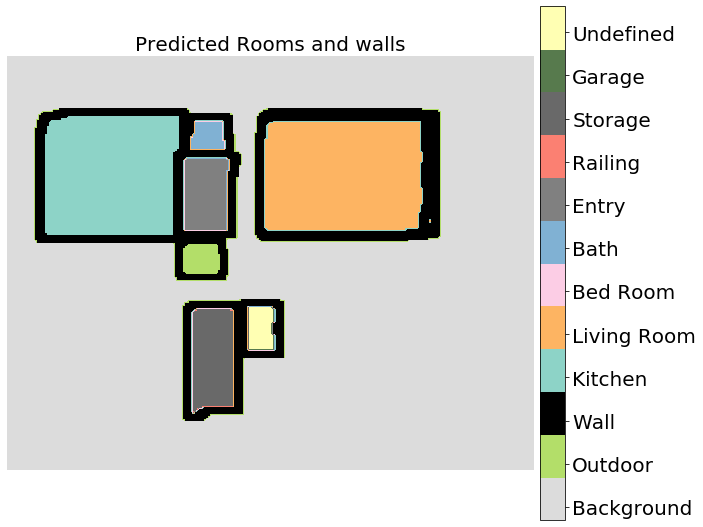

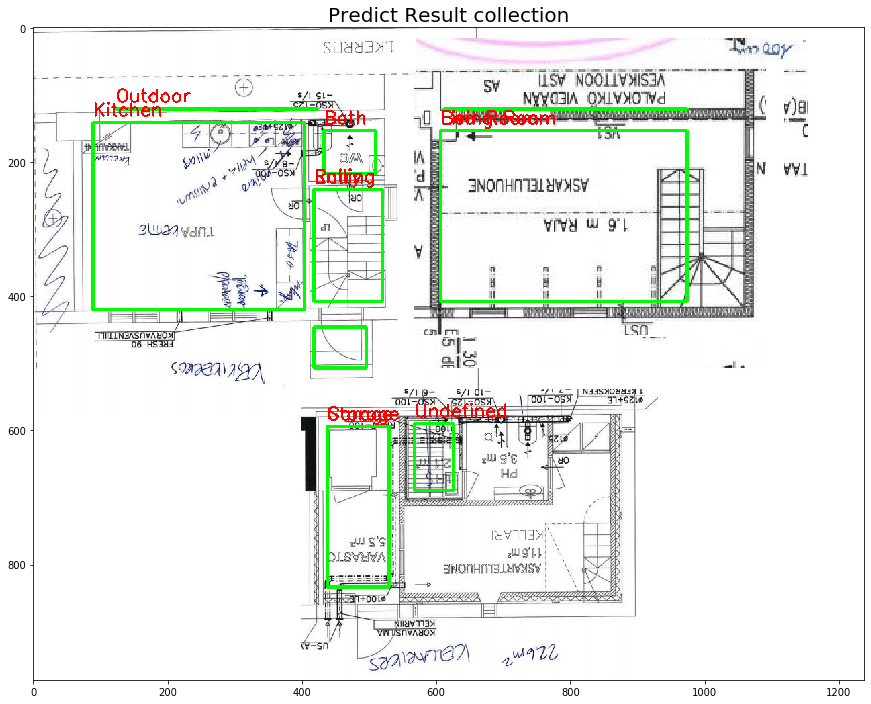

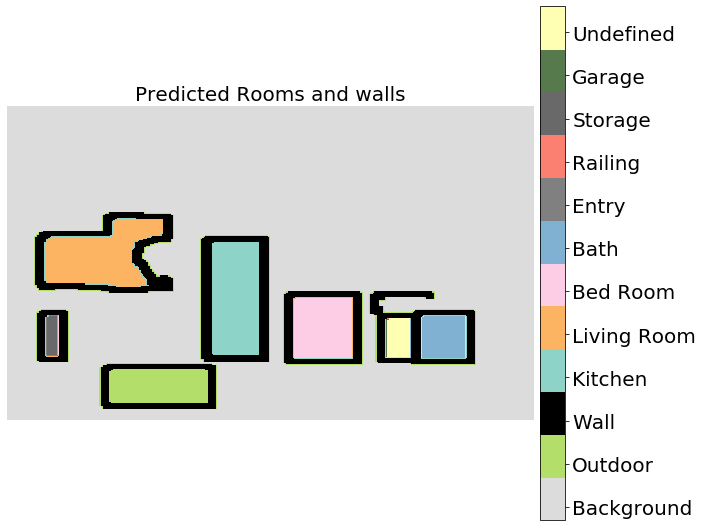

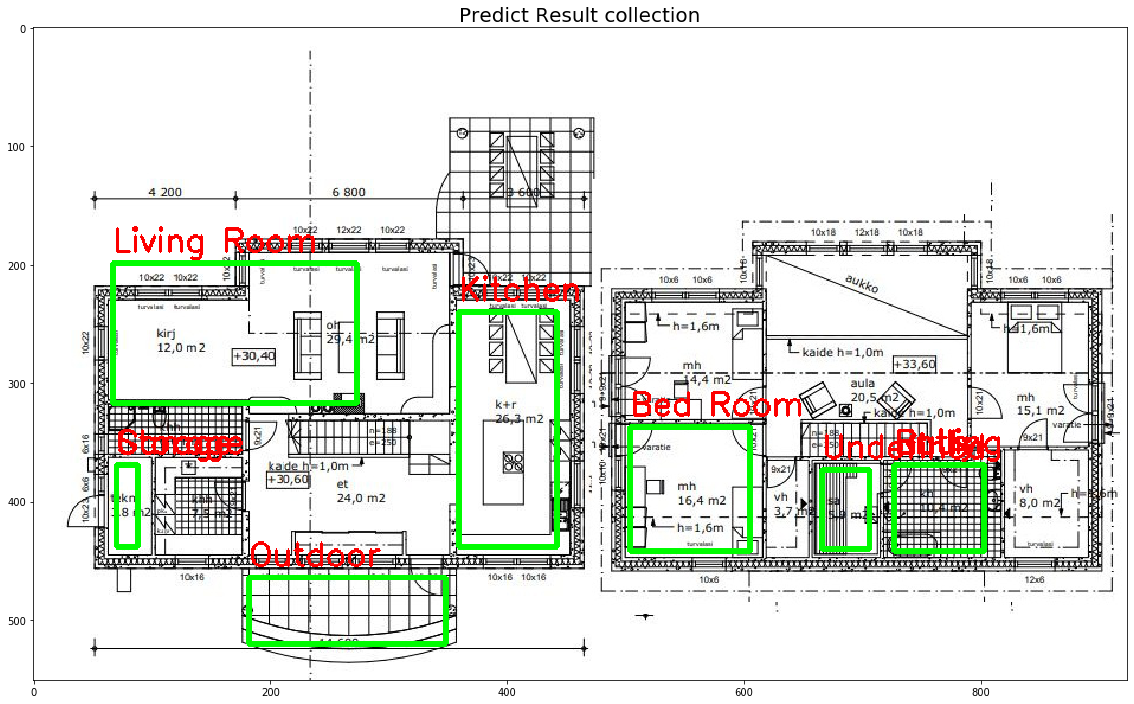

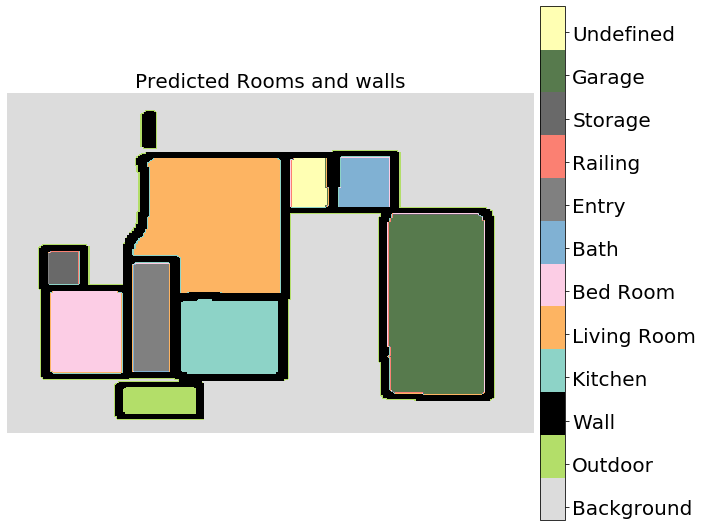

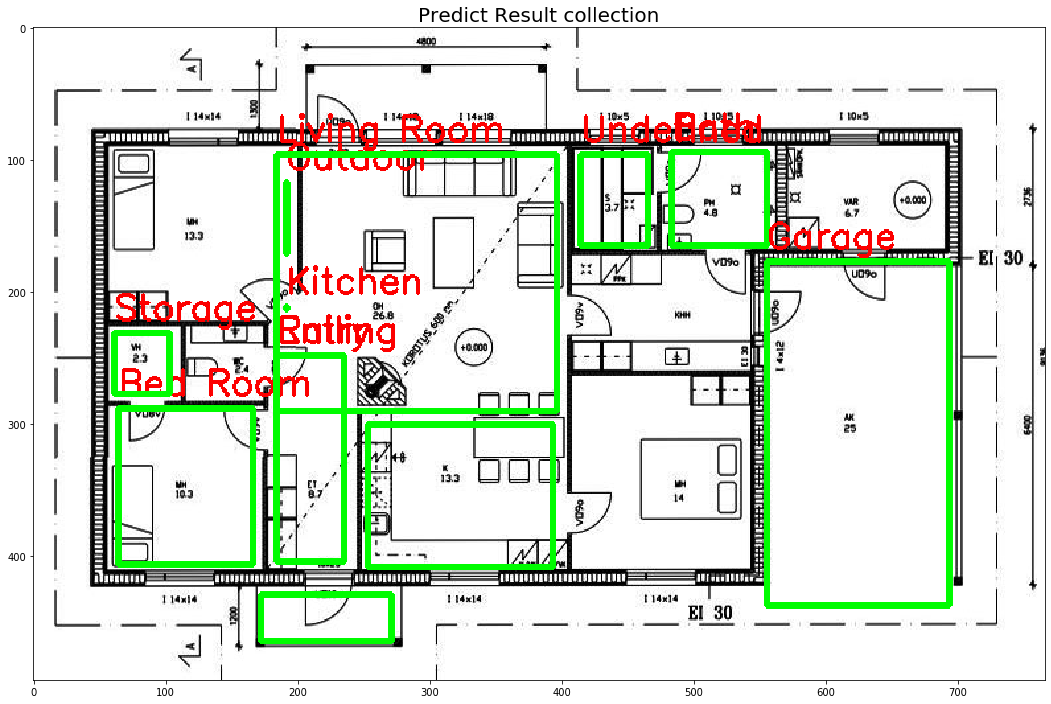

In [11]:
#observe the testset examples
for i in range(5):
    dm = Decode_Maskrcnn(dataset_val, i, model, nms = 1) 
    dm.get_segmap(0.1)
    dm.collect_result()

### Mask R-CNN Result

To evaluate our result, we checked the prediction accuracy and IoU. The metrics and terms were explained in https://arxiv.org/abs/1904.01920v1.

The testing code is in `evaluate_maskrcnn.py`, mainly referred to the code of Kalervo et al. The evaluation was conducted before recovering the segmentation maps to original size.

The evaluated metrics:
- Overall Acc
- Mean Acc
- Mean IoU

**Validation Evaluation**

| Epochs | Overall Acc | Mean Acc | Mean IoU | 
|--------|-------------|----------|----------|
| 0      | 0\.6062     | 0\.4059  | 0\.2912  |   
| 1      | 0\.6178     | 0\.4306  | 0\.3067  |  
| 2      | 0\.6274     | 0\.4492  | 0\.3199  |  
| 3      | 0\.6340     | 0\.4633  | 0\.3291  |  
| 4      | 0\.6657     | 0\.4933  | 0\.3609  |   



**Test Evaluation**

| Epochs | Overall Acc | Mean Acc | Mean IoU | 
|--------|-------------|----------|----------|
| 0      | 0\.6151     | 0\.4231  | 0\.3027  |   
| 1      | 0\.6253     | 0\.4427  | 0\.3163  |  
| 2      | 0\.6322     | 0\.4572  | 0\.3260  |  
| 3      | 0\.6377     | 0\.4702  | 0\.3341  |  
| 4      | 0\.6413     | 0\.4789  | 0\.3395  |   




**Final class accuracy**

| Class       | IoU      | Accuracy|
|-------------|----------|------|
| Background  |  0\.6637 |0.9345|
| Outdoor     | 0\.3717  |0.4266|
| Walls       | 0\.3008  |0.5291|
| Kitchen     | 0\.5251  |0.6309|
| Living Room | 0\.5824  |0.7583|
| Bedroom     | 0\.3506  |0.4206|
| Bath        | 0\.4102  |0.5091|
| Entry       | 0\.3687  |0.4970|
| Railing     | 0\.0230  |0.0352|
| Storage     | 0\.2247  |0.3222|
| Garage      | 0\.1568  |0.5069|
| Undefined   | 0\.0739  |0.0816|







### Discussion

<img src="./deliverable_images/EDA_rooms.png"/>

## B. Unet

As a reminder, Unet was adopted to segment the icon types in a floor plan. Special measures had to be taken to reconstruct segmentation maps from the rasterized image, since the image space taken up by the icons were considerably small compared to the rooms. Thus, we decided to train the Unet by resize-padding the rasterized images to shape (batch, 3, 512,512).

Let us first closely examine the modular components of the Unet.

### Architecture Description

In the code below, we have provided very detailed comments on what each line does in the Unet architecture.

In [9]:
# Referencing work from
# https://github.com/ternaus/robot-surgery-segmentation/blob/master/models.py 

########################################################################################
# MODIFIED & REIMPLEMENTED BY Wisoo (Victor) Song, mail : victor_song@g.harvard.edu    # 
########################################################################################
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvBatchRelu(nn.Module):
    def __init__(self, in_: int, out: int, eps=1e-05, momentum=0.1, affine=True):
        super(ConvBatchRelu, self).__init__()
        self.conv = conv3x3(in_, out)
        self.batchnorm = nn.BatchNorm2d(num_features=out, eps=eps, momentum=momentum, affine=affine)
        #The main purpose of batch normalisation is not for dealing with overfitting 
        #but if you have small batches while training it can have regularization effect.
        #In the paper that it was introduced for dealing with covariate shift,
        #it was mentioned that it should be used before activation function.
        #Consequently, you can use it both in convolutional layers and dense layers,
        #after employing weights and before activation functions. 
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    """
    Decoder block 
    """

    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels
        if is_deconv:
            self.block = nn.Sequential(
                #After every concatenation we again apply two consecutive regular convolutions
                #so that the model can learn to assemble a more precise output
                
                #ConvTranspose is a convolution and has trainable kernels while 
                #Upsample is a simple interpolation (bilinear, nearest etc.) 
                #This section of the if block should be used for this research.
                #Transpose is learning parameter while Up-sampling is no-learning parameters. 
                #Using Up-samling for faster inference or training because it does not require to update weight or compute gradient
                ConvBatchRelu(in_channels, middle_channels), # just 3x3 conv ==> Batch norm ==> relu
                ConvBatchRelu(middle_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                #After every concatenation we again apply two consecutive regular convolutions
                #so that the model can learn to assemble a more precise output
                ConvBatchRelu(in_channels, middle_channels),
                ConvBatchRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)## defined in __init__      
        

class ContourPredictNet(nn.Module):
    def __init__(self, num_classes=1, num_filters=[256,128,64,32,16], pretrained=False, freeze_encoder=True):
        """
         only contains Convolutional layers and does not contain any Dense layer 
         because of this, it can accept image of any size. (since FC layers require one to match up the input size w/ the number of neurons)
        :param num_classes: This should default to 1 because 0 = no center , 1 = center
        :param num_filters: 32 as the default
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        """
        super().__init__()
        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features
        
        self.layer_count = 0
        if freeze_encoder:
            for child in self.encoder.children(): # .children() returns the generator for unet16's layers. 
                # Warning: .children() not only shows the layers involved in the actual forward() func,
                # but also shows all the instance varibles like self.encoder that are just defined as an
                # instance variable.
                # And children() is listed in the order the instance variables are defined in class. 
                for param in child.parameters():
                    param.requires_grad = False
        
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2) # Pool is  applied in the forward()

        

        self.relu = nn.ReLU(inplace=False)
        
        self.conv1 = nn.Sequential(self.encoder[0], #Conv2d (3, 64) (R,G,B) 3 channels, output channel 64
                                                    #Recall:   O = ((I - K + 2P) / S) + 1  ==> 3x3 kernel with pad=1 stride=1 keeps Input dim = Output dim
                                   
                                   self.relu,
                                   self.encoder[2], #Conv2d (64, 64)
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5], #Conv2d (64, 128)
                                   self.relu,
                                   self.encoder[7], #Conv2d (128, 128)
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],#Conv2d(128, 256
                                   self.relu,
                                   self.encoder[12],#Conv2d(256, 256
                                   self.relu,
                                   self.encoder[14],#Conv2d(256, 256,
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],#Conv2d(256, 512,
                                   self.relu,
                                   self.encoder[19],#Conv2d(512, 512
                                   self.relu,
                                   self.encoder[21],#Conv2d(512, 512,
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],#Conv2d(512, 512, 
                                   self.relu,
                                   self.encoder[26],#Conv2d(512, 512, 
                                   self.relu,
                                   self.encoder[28],#Conv2d(512, 512, 
                                   self.relu)

        #                        in_channels, mid_channels , out_channels
        #
        self.dec4 = DecoderBlock(512, 512, 512) # 256 # There is a deconv kernel 4x4, stride=2 pad 1 in the decoder and the rest is 3x3 conv

    # 

                                 #This number is because of the concatenation (center #filters + num_filters*8)
            
        """
        RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1.
        Got 28 and 14 in dimension 2 at /tmp/pip-req-build-4baxydiv/aten/src/TH/generic/THTensor.cpp:689
        """

        self.dec3 = DecoderBlock(512*2, 512, num_filters[0]) # 256
        self.dec2 = DecoderBlock(num_filters[0]*2, num_filters[0], num_filters[1]) # 128
        self.dec1 = DecoderBlock(num_filters[1]*2, num_filters[1], num_filters[2]) # 64
        self.batRelu = ConvBatchRelu(num_filters[2], num_filters[4])
        self.final = nn.Conv2d(num_filters[4], num_classes, kernel_size=1) # 16 channels ==> 1 channel, 

    def forward(self, x):
        print("x shape", x.shape) #x shape torch.Size([10, 3, 224, 224])

        conv1 = self.conv1(x) # conv1 torch.Size([10, 64, 224, 224])
        conv2 = self.conv2(self.pool(conv1)) # maxpool2d 2,2 ==> dimension becomes n/2, n/2. Channel # stays the same just after pool
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3)) # recall that self.conv4 outputs 512 chan.
        center = self.conv5(self.pool(conv4)) # self.conv5 also outputs 512 chan. # conv5 [10 512, 14, 14]
        center_up = self.dec4(center)
#         center = self.center(conv5) # self.center output => num_filters * 8 chan(=256).
#                                                # but the dimensions of each chan. filter are half the size ==> quarter sized image as a whole
        
        #let's say that conv5's dimensions are w x w
        
        # center's dimensions are w/2 x w/2 because it's been maxpooled (2x2)
        # center has 256 chan.
                
        
        """
        To get better precise locations, at every step of the decoder we use skip connections
        by concatenating the output of the transposed
        convolution layers(reconstructed tensors) with the feature maps from the 
        Encoder at the same level:
        """
        
        """In Tensorflow you would use something like tf.image.resize_images
        to get the same height width dimensions as your feature maps in the expansive part
        and then use tf.concat to concatenate the feature maps along the channel axis 
        (typically the 4th axis in BHWC layout).
        https://stackoverflow.com/questions/53068877/u-net-copy-and-crop
        
        This probably means that in pytorch, we can't simply use torch.cat but should use
        
        """

        
#         print("center.shape", center.shape)
        
        dec3 = self.dec3(torch.cat([center_up, conv4], 1)) # 512 + 512 ==> 512 ==> 256
        dec2 = self.dec2(torch.cat([dec3, conv3], 1)) #  256+256 ==> 256 ==> 128
        dec1 = self.dec1(torch.cat([dec2, conv2], 1)) # 128 + 128 ==> 128 ==> 64
        
        act = self.batRelu(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(act), dim=1) # The goal output should have (imgsize, imgsize, numclasses) where numclasses vector adds up to probability 1.
        else:
            x_out = self.final(act)
        
        print("******xout size:", x_out.shape)

        return x_out

Now, let us supply our unet with the number of classes, so that we have the proper log_softmax results as the output.

In [11]:
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

In [12]:
icon_model = ContourPredictNet(
                            num_classes=len(icon_classes),
                            num_filters=[256,128,64,32,16],
                            pretrained=True,
                            freeze_encoder=False)
icon_model.load_state_dict(torch.load('./models/unet2.pth'))

<All keys matched successfully>

<img src="./deliverable_images/unet_train_process3.png" height=500/>

(The above chart is a screen-captured image from /contour_masknet.ipynb)

### Unet Validation and Visualization

In [13]:
class ContourMaskDataset(Dataset):
    """
        phase: train / test
        transform: applies appropriate transformations to generate contourmap & perform data augmentation
        
        
    """
    def __init__(self, img_size=512, phase='train', transform_it=True, batch_size=4):
        self.root_path = '/n/pfister_lab2/Lab/wisoo/DS2-final/data/cubicasa5k/'
        self.transform = transform_it
        #This is annotation path
        self.ann_path = '{}.txt'.format(phase)
        aug = Compose([
            ResizePaddedTorch((0,0), data_format='dict', size=(img_size,img_size) ),
#             RandomRotations(format='cubi'),
            DictToTensor()
        ])
        self.normal_set = FloorplanSVG(self.root_path, self.ann_path, format='txt', augmentations=aug)
        self.dataloader = DataLoader(self.normal_set, batch_size=batch_size, num_workers=0) # this is torch.utils.data.DataLoader
        self.data_it = iter(self.dataloader)
        self.img_size = img_size
        self.num_images = len(self.data_it)
        self.batch_size = batch_size
#         self.batch_offset = 0
        
    def __len__(self):
        return self.num_images
    
    def alter_path_to_n(self, path):
        return '/n/'+'/'.join(path.split("/")[2:])
    
    
    def get_one_item(self, idx):
#         print(dir(self.normal_set))
        data = self.normal_set.__getitem__(idx)
        img = data["image"]
        label = data["label"]
        file = io.imread(img)
        io.imshow(file)
        
        #This is the one-lit center maps, one for each instance
            # First use the rescale
        
        
        
        return img, None, None
        
           
    def apply_transformation(self, image, center_map, rotation_range=30, collapse=True):
        rotate = T.RandomRotation(rotation_range)
        toT = T.ToTensor()
        
        image = Image.fromarray(image)
        ##### NOTE THAT TRANSFORM FUNCTIONS CAN ONLY BE APPLIED TO PIL IMAGE, but Dataloader requires tensor style.
        #### So have to go from (tensor / numpy ) ===> (PIL)  ===> (tensor / numpy)
        image = rotate(image)
        image = toT(image)
        
        if collapse:
                center_map = center_map.sum(0)
                center_map = center_map.squeeze() ## squeeze because (224,224,1 ) can't be converted by Image.fromarray()
        print(center_map.shape)
        center_map = Image.fromarray(center_map.astype(np.uint8))
        center_map = rotate(center_map)
        center_map = toT(center_map)
        
        print("center_map shape: ", center_map.shape)
        print("image shape: ", image.shape)
        
        return image, center_map
            
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            img_list = []   # should change to tensor for efficiency later
            center_map_list = []
            mask_stacked_list = [] 
            for index in idx:
                img, center_map_stacked, mask_stacked = self.get_one_item(index)
                img_list.append(img)  # should change to tensor for efficiency later
                center_map_list.append(center_map_stacked)
                mask_stacked_list.append(mask_stacked)
            
            if collapse_center_map:
                for ith, c_map in enumerate(center_map_list):
                    c_map = c_map.sum(0)
                    center_map_list[i] = c_map
            
            return img_list, torch.tensorcenter_map_stacked
                
#             result_dict = {'image': torch.tensor(img_list), 'center_map': center_map_stacked, 'mask': mask_stacked}
                    
        else:
            #idx is an int
            
            img, center_map_stacked, mask_stacked = self.get_one_item(idx)
            if self.transform:
                img, center_map_stacked = self.apply_transformation(img, center_map_stacked, self.collapse)
                
            
            
            return img, center_map_stacked
            

In [14]:
icon_test =  ContourMaskDataset(img_size=512, phase='test', transform_it=True)

In [ ]:
icon_model.eval()
test_count = 0
n_icons = 11
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
icon_model.cuda()
evaluator = runningScore(n_icons)
for i, samples in tqdm(enumerate(icon_test.dataloader), total=len(icon_test.dataloader)):
    test_count += 1
    images = samples['image'].cuda(non_blocking=True)
    labels = samples['label'].cuda(non_blocking=True)
    preds = icon_model(images)
    print("preds shape:", preds.shape)
    for idx, pred in enumerate(preds):
        
        icon_index_map = torch.argmax(pred, dim=0, keepdim=True)
        icon_index_map = icon_index_map.cpu().data.numpy()
        
        print(icon_index_map.shape)
#         icon_index_map = icon_index_map.normal_cuda()
#         icon_image = ToPILImage(icon_index_map)
#         plt.imshow(icon_image)
        plt.figure(figsize=(15,15))
        ax1 = plt.subplot(1,3,1)
        ax1.imshow(icon_index_map[0], cmap='icons', vmin=0, vmax=n_icons-0.1)
        ax2 = plt.subplot(1,3,2)
        label_np = labels[idx].cpu().data.numpy()
#         image_np = images[idx].cpu().data.numpy()
        image_np = images[idx].cpu()
        
        
        ax2.set_title("Real Labels")
        ax2.imshow(label_np[22], cmap='icons', vmin=0, vmax=n_icons-0.1)
        ax3 = plt.subplot(1,3,3)
        ax3.set_title("Real Images")
        ax3.imshow(image_np.permute(1,2,0))
        plt.pause(0.5)
        
#         plt.imshow(np.transpose(icon_image, (1,2,0)), cmap='icons', vmin=0, vmax=n_icons-0.1)
        
        
        
    labels = labels[:,22,:,:]  # Icon segmentations at index 22
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    if test_count == 2:
        break

#### Your GPU may run out of memory while running above.

<img src="./deliverable_images/unet_result_2b.png" height=500/>

(The above images were taken from contour_masknet.ipynb in wisoo_dev branch to preven OOM ERROR while running this notebook.)

### Unet Result

*Test Evaluation*

| Epochs | Overall Acc | Mean Acc | Mean IoU | 
|--------|-------------|----------|----------| 
| 4      | 0\.9770    | 0\.5317  | 0\.4508  |   




*Final class accuracy*

| Class       | IoU      | Accuracy|
|-------------|----------|------|
| No Icon  |  0\.977 |0.990|
| Window     | 0\.6356  |0.7449|
| Door       | 0\.5673  |0.6130|
| Closet     | 0\.5251  |0.7130|
| Electrical Appliance | 0\.5725  |0.6915|
| Toilet     | 0\.5021  |0.5547|
| Sink        | 0\.5157  |0.6583|
| Sauna Bench       | 0\.5667  |0.8106|
| Fire Place     | 0\.0685  |0.0720|
| Bathtub     | 0\.0  |0.0|
| Chimney      | 0\.0  |0.0|

Observing the performance table above, using 512 x 512 definitely proved to be a good choice. The Unet actually outperformed the MaskR-Cnn (which is a more recent architecture), even though the detection targets (icons) are smaller than rooms in size.

## C. CGAN

###  Modularized Problem Definition for CGAN:
Given a segmentation with empty space, we are hoping that the contextual-conditional GAN will help us identify what kind of room types/ icons can be put inside that area by using the contextual information of its surrounding icons, rooms and junctions.

We apply mask-one out strategy to the original dataset to create a dataset that is lacking partial information. In turn, the training phase uses the masked out element as the ground truth label.



<img src="./deliverable_images/true_seg.png" height=500/>

The segmentation Map (as plotted above is a 2 dimensional array with label (1-11) for rooms and (1-12) for icons, backgrounds are changed to 15 to differentiate with missing part (which is labeled 0).

**True Segmentation Map**:
   The true segmentation map of 1 particular floor plan.
   
**Map with missing part**:
   The input that is fed in the GAN to generate context image with all other labels unchanged but with the target recommendation type (in this bedroom index 5) set to zeros (as indicated by the dark blue blocks in the plot.
   
**Missing part**:
   The true missing labels plot of the Map with missing part.

**Relationship**:
Missing part  + Map with missing part = True Segmentation Map


As this example shows, we attempt to infer the missing part (in this example Bedrooms) by using the network to infer the Map_with_missing_part images of our segmentation maps. 
    We developed context-conditional generative adversarial networks (CC-GANs) which are conditional GANs where the generator is trained to fill in a missing image patch and the generator and discriminator are conditioned on the surrounding pixels. In particular, the generator receives as input an image with a given feature( room type or icon) masked and then outputs an entire image. 

### Achitecture Description

**NOTE: This Context-Encoder Framework is built on the work done on  https://github.com/eriklindernoren/Keras-GAN/tree/master/context_encoder with different functions but same class structures. The reference paper is https://arxiv.org/abs/1611.06430**

The architecture of our generative model is consists of a sequence of convolutional layers with subsampling (but no pooling) followed by a sequence of fractionally-strided convolutional layers. The input is a bunch of segmentation maps as plotted above) with dimension. is (Num of image * 256 *256 *1)

The generator is an autoencoder that takes the image of a mask_with_missing part img and aims to re-fill the  missing part with the proper label (say 5 for room and 6 for bath room) with out put (256,256,1) or at least highlight the correct  difference

The discirminator takes either the true missing part or the fake version and output 0 or 1.

In generative model, each of the three convolutional layer(256,128,8) is followed by a Leaky rectified linear layer, followed by a spatial batch normalization in encoder, while in decoder, each upsampling and convolutional layer is followed by Leaky rectified linear layer and a spatial batch normalization in the end. The discriminator took the completed image as input with 3 convolutional layers each followed by Leaky rectified linear layer to give to binary output.

In [18]:
class ContextEncoder():
    
    def __init__(self,Training_set,Type):
       
        self.TRAIN = Training_set
        self.index = Type
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols,self.channels)
        
        #The missing shape will be the same as the input image
        #But only with the missing part of the picture non-zero
        self.missing_shape = (self.img_rows, self.img_cols,self.channels)
        
        
        # ---Build the generator----#
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)
        
        # ---Build the generator----#


        #-- Build and compile the discriminator---#
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer= Adam(0.0002, 0.5),
            metrics=['accuracy'])
        #-- Build and compile the discriminator-#

      
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # Trains generator to fool discriminator
        self.GAN = Model(masked_img , [gen_missing, valid])
        self.GAN.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.995, 0.005],
            optimizer=Adam(0.0002, 0.5))

        
    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv2D(256, kernel_size=3, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(128, kernel_size=3,strides = 2, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(8, kernel_size=3,strides=2,  padding="same"))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(128, kernel_size=1, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2DTranspose(256, kernel_size=3, activation ="relu", padding="same"))
        model.add(UpSampling2D())
        model.add(BatchNormalization())
        model.add(Conv2DTranspose(self.channels, kernel_size=3, padding="same", activation ="tanh"))

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)
    

    def build_discriminator(self):
        '''
        This function build a discriminatro that aims to identify real/fake image
        
        '''

        model = Sequential()
        model.add(Conv2D(512, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(LeakyReLU())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)
    
    #Masking specific type of icons/ rooms
    def mask_type(self,imgs):  
        '''
        #Index is for what part of the room you would like to mask


        This function takes input imgs and out put the masked_img (without certain icon)
        and the missing_icon itself
        '''
        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty_like(imgs)
        for i, img in enumerate(imgs):
            img = img.reshape(256,256)
            temp = img.copy()
            # Single out the missing icon
            temp[temp != self.index] = 0 
            temp_re = temp.reshape(256,256,1)

            missing_parts[i] = temp_re
            # Use initial img to generate the masked img
            masked_imgs[i] = (img- temp).reshape(256,256,1)

        return masked_imgs,missing_parts

    def train(self, epochs, batch_size=128, sample_interval=50):


        # Rescale -1 to 1
        X_train = self.TRAIN
        
        print("starting epoch...")
        for epoch in range(epochs):
            
            print("epoch {}".format(epoch))

            # ---------------------
            #  Train Discriminator
            # Select a random batch of images
            imgs = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
            
            
            #Single Out the masked image
            masked_imgs, missing_parts = self.mask_type(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)
            
            
            # Train the discriminator on true missing images
            d_loss_real = self.discriminator.train_on_batch(missing_parts,  np.ones((batch_size, 1)))
            
            #Train the discriminator on fake image
            d_loss_fake = self.discriminator.train_on_batch(gen_missing,np.zeros((batch_size, 1)))
            d_loss = 0.8 * np.add(d_loss_real, d_loss_fake)
            
            
            #----Training Generator----#
            g_loss = self.GAN.train_on_batch(masked_imgs, [missing_parts, np.ones((batch_size, 1))])

            # Plot the progress
            print ("%d , Discriminator loss: %f ,Generator loss: %f, mse: %f" % (epoch, d_loss[0], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                #Print a random figure to see how process goes
                idx = np.random.randint(0, X_train.shape[0], 1)
                print("index",idx)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
                

    def sample_images(self, epoch, imgs):
        
        #plot img and save
        masked_imgs,miss_part= self.mask_type(imgs)

        gen_missing = self.generator.predict(masked_imgs)
        
        fig, axs = plt.subplots(1,5,figsize = (20,15))

        
        IMG = imgs[0].reshape(256,256)
        GEN = gen_missing[0].reshape(256,256)

        
        axs[0].imshow(IMG)
        axs[0].set_title("True Img")
        
        axs[3].imshow(GEN)
        axs[3].set_title("Predicted")
        
        axs[2].imshow( miss_part[0].reshape(256,256))
        axs[2].set_title("True Missing part" + room_classes[self.index])
        
        axs[1].imshow( masked_imgs[0].reshape(256,256) )
        axs[1].set_title("Masked Img: without " + room_classes[self.index])
        
        fig.savefig("progress/%d.png" % epoch)

### Visualizing Final Results (Generation)

<img src="./deliverable_images/epoch2.png" height=500/>

 The above shows a failure to re-highlight the Missing Part in the Prediction img but rather dampens out the segmentation map. The icon prediction is indifferentiable among different icons

# Conclusion

### TODOs

### A. Mask R-CNN

Due to the limit of time, we still have several TODOs in this part.

First, according to the validation and test evaluation, we can see the overall acc/mean acc/ mean IoU is still improving in both validation and test set. That means we haven't fully trained our model. The limit is not only due to the long training time each epoch but also the limit on AWS budget.

Second, according to the EDA result above, that the room counts are not evenly distributed across the dataset. To increase the class accuracy of garage it is necessary to rebalance the dataset.

Finally, the wall recovery is very rough. We may instead combine with semantic segmentation techniques such as UNet and more preprocessing techniques to predict the walls. 

### B. Unet

Considering that we only had enough time to train for 5~10 epochs, the 97% accuracy was very impressive. It would be interesting to continue training the Unet using the current setup with more epochs.


### Result Analysis

In terms of segmentation, Mask R-cnn & Unet's results are no better than that of Kalervo et al.'s. Besides the reason above, our room detection algorithm did not process the junction points. For some classes, this proved to be very critical to segmentation. (i.e toilet icons in bathrooms). 

There are also some interesting findings in the class-wide accuracy. We can see some rooms have higher accuracy than others such as living room, bath, and kitchen. That may attribute to some special icons in these kinds of rooms. The accuracy of walls is over 0.5, indicating the wall recovery meets the average. The accuracy of railing and the undefined are extremely low. Because railing is very thin in the original floorplan. The likelihood of right prediction on pixel is very low. Finally, the undefined rooms are very hard to conclude for our model. Removing it from the input may on the other hand increase the accuracy of other rooms. This is actually a very practical and feasible idea since it is meaningless to recover that room on floorplan without knowing the room type. In our final delivered visualization result, humans could regard all unboxed areas as undefined.

Our Context-conditional Generative Adversarial Network doesn’t give us desired output as expected. Our missing part is scattered around the place and the auto-encoder fails to identify the correct missing parts. Given this result, we presented following reasons for that and hope to improve in further steps.


1) The design of the generator (autoencoder) needs to be thought through more carefully.

2)There are a lot of missing classification on the training data.  We realized an approximately 20% lack of room labels in our training process which might hamper the performance. 

3) The limitation of training epochs. Satisfying performance requires at least 5000 epochs on a 32 x32 dataset with 3 color channels. Our segmentation map has each dimension 256 x256x1 therefore, extremely hard to train sustainably on Hub.
The icon types are scattered and not regularly shaped. The referenced paper only takes a look on a predefined masking face ( only 1 rectangle) that is at least 75% smaller than the original image. Since the icon types and room types are not  necessarily rectangular, and tend to scatter around across different areas with varying sizes( some of them are too small and some of them are too big compared to the true image). It is very have to predict on every missing spot by simply doing contextual analysis on the masked segmentation map. In other words, we are kind of expecting the GAN to figure out not only the type but the location of the recommended room/icon type for each image. This problem is particularly troublesome in icons since the icon segmentation is dominated by backgrounds that do not incorporate any useful contextual information.

4).Relatively monotonous images. Generative adversarial networks have shown impressive performance on many diverse datasets. However, samples are most coherent when the set of images the network is trained on comes from a limited domain (eg. faces), which is just the case our dataset. We seek to train on one-hot-encoded floor plans without any further information or nuances between pixels.Most of them are just color blocks with integers. All images have only one channel and are relatively the same apart from the number of different types rooms, the location of rooms, different types of icons and the location of different icons. Even though there are 12 room classes and 11 icon classes, the difference between each other is slight, those horizontal lines, vertical lines and shapes can not be easily learned using Generative Adversarial Network compared with colorful and diverse image datasets used in those successful cases.

5)Finally, the complexity and scope of our goal. The typical task that context conditional GANs address is to determine if a part of an image is real or fake given the surrounding context. However, the relationship of different rooms and icons on a single floor plan is not so strong and close, not like a image of bird or a car. So, using surrounding context may not give a determined prediction of the missing part. In addition to that, we not only seek to recover the missing part, but also to mark the existed part as zero, which increased the difficulty of our task.

Overall while we attempt to tackle the room/icon recommendation problem using a context conditional GAN, we generated unsatisfactory results due to the training resource limitation,project time constraint  and the inherent lack of contextual continuity embeded in the input segmentation map.

### Future work
Given the discussion above, there are several ways we propose to improve the result.

1. Rebalance the data before training.
2. Increase training epochs until validation reaches the optimum.
3. Include the information of junction points and icons to the inputs.
4. Remove the undefined room information from the training.
5. Combine the results with semantic segmentation methods for some non-patch instance recovery.
6. Better combine the segmentation map with additional features possibly such as size, junctions , and transform this contextual encoder GAN into an INFOGan that not only incorporate a noise vector but also a vector of latent variables (in our case size, junctions ,etc) 


### Summary
In summary, we are the first to try the object detection method on Cubicasa dataset to predict both the rooms and segmentation maps. Also, our result generated  visualization of room detection on the floorplan. Although there's no improvement in room segmentation accuracy compared to the work of Kalervo et al., we implemented a segmentation-to-generation neural network that can be very useful in industrial settings. If time allows, it would be interesting to see how the entire architecture's performance improves when the number of epochs are increased. (As of now, we only trained for 5~10 epochs per model.)